<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/saliency/fer2013_pawan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%tensorflow_version 2.x
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
import PIL 
from tensorflow.keras import backend as K
from tensorflow.keras import Model

%matplotlib inline

In [0]:
from google.colab import drive
# drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/video_feedback_service/cs230 project/collab/fer2013/fer2013.csv')

#print('Number of samples in the dataset: ', data.shape[0])
# Transform images from strings to lists of integers. TODO: use an array cast
data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

In [0]:
emotion_cat = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

# See the target distribution (check for imbalance)
#target_counts = data['emotion'].value_counts().reset_index(drop=False)
#target_counts.columns = ['emotion', 'number_samples']
#target_counts['emotion'] = target_counts['emotion'].map(emotion_cat)
#target_counts

# Select randomly 10 images
#random_seed = 1
#data_sample = data.sample(10, random_state=random_seed)
#f, axarr = plt.subplots(2, 5, figsize=(20, 10))

#i, j = 0, 0
#for idx, row in data_sample.iterrows():
#    img = np.array(row['pixels']).reshape(48,48)
#    axarr[i,j].imshow(img, cmap='gray')
#    axarr[i,j].set_title(emotion_cat[row['emotion']])
#    if j==4:
#        i += 1
#        j = 0
#    else:
#        j += 1

In [0]:
data_train = data[data['Usage']=='Training']
#print('Number samples in the training dataset: ', data_train.shape[0])

data_dev = data[data['Usage']=='PublicTest']
#print('Number samples in the development dataset: ', data_dev.shape[0])

# Retrieve train input and target
X_train, y_train = data_train['pixels'].tolist(), data_train['emotion'].values
# Reshape images to 4D (num_samples, width, height, num_channels)
X_train = np.array(X_train, dtype='float32').reshape(-1,48,48,1)
# Normalize images with max (the maximum pixel intensity is 255)
X_train = X_train/255.0

# Retrieve dev input and target
X_dev, y_dev = data_dev['pixels'].tolist(), data_dev['emotion'].values
X_dev = np.array(X_dev, dtype='float32').reshape(-1,48,48,1)
X_dev = X_dev/255.0

In [71]:
#Baseline model
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(48,48,1),name="input"),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv1"),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv2"),
    MaxPool2D(pool_size=(2,2),name="maxpool1"),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv3"),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv4"),
    GlobalAveragePooling2D(),
    Dense(7,input_shape=(64,1),activation='softmax',name='fc-softmax')
])

print("Accuracy after training")
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Accuracy after training


In [72]:
model.fit(X_train,y_train,batch_size=32,epochs=3,validation_data=(X_dev, y_dev))

Train on 28709 samples, validate on 3589 samples
Epoch 1/3
28709/28709 [==============================] - 7s 228us/sample - loss: 1.8016 - accuracy: 0.2493 - val_loss: 1.7929 - val_accuracy: 0.2536
Epoch 2/3
28709/28709 [==============================] - 6s 208us/sample - loss: 1.7796 - accuracy: 0.2583 - val_loss: 1.7622 - val_accuracy: 0.2616
Epoch 3/3
28709/28709 [==============================] - 6s 209us/sample - loss: 1.7495 - accuracy: 0.2798 - val_loss: 1.7207 - val_accuracy: 0.2934


In [0]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  im = ((im + 1) * 127.5).astype(np.uint8)
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def ShowDivergingImage(grad, title='', percentile=99, ax=None):  
  if ax is None:
    fig, ax = P.subplots()
  else:
    fig = ax.figure
  
  P.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
  fig.colorbar(im, cax=cax, orientation='vertical')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = np.asarray(im)
  return im / 127.5 - 1.0

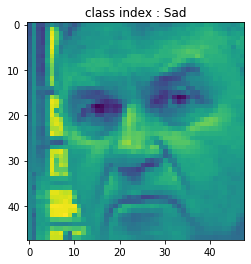

In [78]:
# get a single image and plot it 
indx=2 
label =  "class index : {}".format(emotion_cat[y_dev[indx]])
plt.title(label = label )
plt.imshow(X_dev[indx].reshape(48,48) )

In [81]:
single_example.shape

(1, 48, 48, 1)

# Vanilla Gradients

In [80]:

# this is how you do vanilla gradients 

# reshape individual image 
single_example = X_dev[indx].reshape(1,48,48,1)

# four lines are needed to generate a function that computes the gradients 
# remember that you need to specific which class the image belongs to. 
# this is specified in the example_model_output. 
input_tensors = [model.input]
example_model_output = model.output[0][y_dev[indx]]
gradients = model.optimizer.get_gradients(example_model_output, model.input)
compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

gradient_fun  = Model(inputs= model.input, outputs=gradients)
gradients_value = gradient_fun(single_example.astype("float32"))



ValueError: ignored

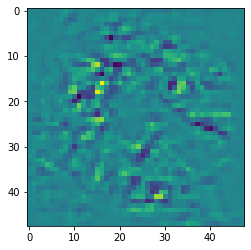

In [51]:
# plot the gradient values 
plt.figure()
plt.imshow(gradients_value.numpy().reshape(48,48))
plt.show()

# Class activation maps

In [0]:
label = int(y_dev[indx])
last_layer_weights = model.weights[-2]
get_conv_layer = Model(inputs=model.input, outputs=model.get_layer("conv4").output)
layer_feature_maps = get_conv_layer.predict(single_example)
weights = last_layer_weights[:,label]

cam = 0 
for k in range(layer_feature_maps.shape[-1]): 
     cam += weights[k]*layer_feature_maps[:,:,:,k]

        
cam = tf.reshape(cam,[24,24,1])
cam_resized= tf.image.resize(cam,[48,48])


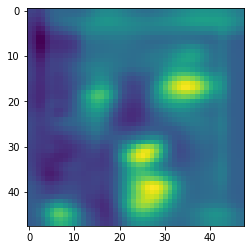

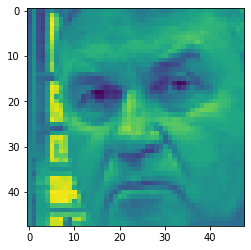

In [77]:
cam_numpy = cam_resized.numpy()
new_cam = cam_numpy.reshape(48,48)
import matplotlib.pyplot as plt
plt.imshow(new_cam)
plt.figure()
plt.imshow(single_example.reshape(48,48))


In [70]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 48, 48, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 48, 32)        9248      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 24, 24, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 24, 24, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 24, 24, 64)        36928     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
fc-softmax (Dense)           (None, 7)                